In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SGD or Adam? IF learning rates be selected appropriately for each one, Adam converges faster than SGD. Steady state loss of Adam seems to be better. 

Dropout? Our initial plain network has overfitted (train_Accu: 83%, test_Accu: 70%). Using dropout, test and train Accuracy has increased. (train_Accu: 97%, test_Accu: 77%)

In [2]:
df_train = pd.read_csv('./Data/HW2_data/Q3_train.csv')
df_test = pd.read_csv('./Data/HW2_data/Q3_test.csv')

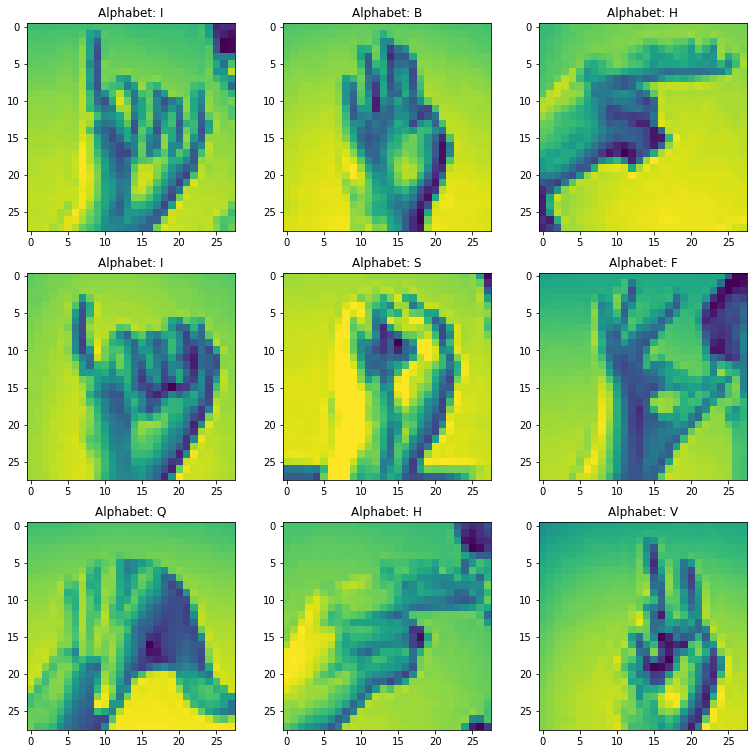

In [3]:
import random
k = 9
idx = random.sample(range(len(df_train)), 9)
plt.figure(1, figsize=(13, 13))
for i, j in enumerate(idx):
    Img_flat = df_train.iloc[j, 1:].values
    lable = df_train.iloc[j, 0]
    Img = np.reshape(Img_flat, (28, 28))
    plt.subplot(3, 3, i+1)
    plt.imshow(Img)
    plt.title(f'Alphabet: {chr(lable + 65)}')

In [4]:
# per pixel normalization
df_feat_train = df_train.iloc[:, 1:]
df_feat_tr_nor = (df_feat_train - df_feat_train.mean())/df_feat_train.std()
df_train_normal = pd.concat([df_train.iloc[:, 0], df_feat_tr_nor], axis = 1)

df_feat_test = df_test.iloc[:, 1:]
df_feat_test_nor = (df_feat_test - df_feat_train.mean())/df_feat_train.std()
df_test_normal = pd.concat([df_test.iloc[:, 0], df_feat_test_nor], axis = 1)

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, df, transform = None, target_transform = None):
        self.df = df
        self.transform = transform 
        self.target_transform = target_transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        Img_flat = self.df.iloc[idx, 1:].values
        lable = self.df.iloc[idx, 0]
        Img = np.reshape(Img_flat, newshape= (28, 28)).astype('float32')
        if self.transform:
            Img = self.transform(Img)
            lable = self.target_transform(lable, dtype = torch.long)
        return Img, lable

In [6]:
from torch.utils.data import random_split
Tr_Data = MyDataset(df_train_normal, transforms.ToTensor(), torch.tensor)
Test = MyDataset(df_test_normal, transforms.ToTensor(), torch.tensor)
SplitData = random_split(Tr_Data, [0.90, 0.10])
Train = SplitData[0]
Val = SplitData[1]
print(len(Tr_Data), len(Train), len(Val))

27455 24710 2745


In [13]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(Train, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(Val, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(Test, batch_size = batch_size, shuffle = True)

In [98]:
import torch.nn as nn
class NeNet(nn.Module):
    def __init__(self):
        super(NeNet, self).__init__()
        self.flatten = nn.Flatten()
        self.Linear_Relu = nn.Sequential(
        nn.Linear(in_features=784, out_features=900), 
        nn.ReLU(), 
        nn.Linear(in_features=900, out_features=500),
        nn.ReLU(), 
        nn.Linear(in_features=500, out_features=200),
        nn.ReLU(), 
        nn.Linear(in_features=200, out_features=25),
        nn.ReLU())
    def forward(self, X):
        X = self.flatten(X)
        logits = self.Linear_Relu(X)
        return logits

class NeNet_D(nn.Module):
    def __init__(self):
        super(NeNet_D, self).__init__()
        self.flatten = nn.Flatten()
        self.Linear_Relu = nn.Sequential(
        nn.Dropout(p = 0.1),
        nn.Linear(in_features=784, out_features=900), 
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=900, out_features=500),
        nn.ReLU(),
        nn.Dropout(p = 0.3),
        nn.Linear(in_features=500, out_features=200),
        nn.ReLU(), 
        nn.Linear(in_features=200, out_features=25),
        nn.ReLU())
    def forward(self, X):
        X = self.flatten(X)
        logits = self.Linear_Relu(X)
        return logits

In [122]:
Lr = 1e-5
epoch = 20
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = NeNet_D()
model = model.to(device)
optimizer = torch.optim.Adam(params= model.parameters(), lr=Lr, weight_decay=0.0)
#optimizer = torch.optim.SGD(params= model.parameters(), lr=Lr)
loss_func = nn.CrossEntropyLoss()

In [123]:
def train_loop(model, dataloader):
    LD = len(dataloader.dataset)
    for i, (X, y) in enumerate(dataloader):
        y = y.squeeze()
        X, y = X.to(device), y.to(device)
        ypred = model(X)
        loss = loss_func(ypred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'loss = {loss.item():5f}     [{i*batch_size:5}\{LD:5}]')
def test_loop(model, dataloader):
    LD = len(dataloader.dataset)
    LB = len(dataloader)
    loss = 0
    Accu = 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.squeeze()
        with torch.no_grad():
            ypred = model(X)
            loss += loss_func(ypred, y)
            Accu += (torch.argmax(ypred, dim = 1)==y).type(torch.float).sum().item()
    print(f'Test/Val Loss = {loss.item()/LB:5f}  ,  Accuracy = {100*Accu/LD:2f}%')

In [124]:
for k in range(epoch):
    print(f'\nEpoch: {k}-----------------------------------------')
    model.train()
    train_loop(model, train_dataloader)
    model.eval()
    test_loop(model, val_dataloader)
print('Done!')


Epoch: 0-----------------------------------------
loss = 3.222386     [    0\24710]
loss = 3.191422     [ 6400\24710]
loss = 3.170489     [12800\24710]
loss = 3.124250     [19200\24710]
Test/Val Loss = 3.039659  ,  Accuracy = 25.063752%

Epoch: 1-----------------------------------------
loss = 3.060154     [    0\24710]
loss = 3.019545     [ 6400\24710]
loss = 2.927045     [12800\24710]
loss = 2.647186     [19200\24710]
Test/Val Loss = 2.560850  ,  Accuracy = 34.681239%

Epoch: 2-----------------------------------------
loss = 2.611252     [    0\24710]
loss = 2.403807     [ 6400\24710]
loss = 2.426543     [12800\24710]
loss = 2.196764     [19200\24710]
Test/Val Loss = 2.055162  ,  Accuracy = 44.663024%

Epoch: 3-----------------------------------------
loss = 2.034789     [    0\24710]
loss = 1.997981     [ 6400\24710]
loss = 1.889228     [12800\24710]
loss = 1.781421     [19200\24710]
Test/Val Loss = 1.731559  ,  Accuracy = 53.624772%

Epoch: 4---------------------------------------

In [125]:
model.eval()
test_loop(model, test_dataloader)

Test/Val Loss = 0.723424  ,  Accuracy = 77.467931%
